<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/3_AE_v6_MLP_mnist_PCA_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：オートエンコーダを理解する

### 概要：MNISTの手書き文字画像をオート・エンコーダで学習（自己教師あり学習）して潜在変数を得る

<br>
&copy; 2021-2024 Hiro Kimura
<br>




### ポイント
- **オートエンコーダ**は自己符号器とも呼ばれ，自分自身を教師として学習し，自分と同じものを生成するように学習する．
- オートエンコーダの学習は教師ラベルを作成する必要がないことから，「教師なし学習」または「**自己教師あり学習**」とも呼ばれる．
- 現在の機械学習の最大の弱点は，教師ラベルを作成しなければならない**学習コストの高さ**にあるが，オートエンコーダではこれが必要ないことから，適用範囲が広がる可能性を持っている．
- エンコーダの中間層として得られる**潜在変数**からは，自身に似た画像を生成できることから，**入力画像の特徴量を内在**していると考えられる
- 潜在変数は，入力データの次元を大幅に次元削減した**特徴量ベクトル**として得られ，異常検知やクラスタリングなどに利用できる可能性がある


### この教材では，以下を行う：
A. オートエンコーダで自己教師あり学習を行う
  -  データセットにはMNIST(Modified National Institute of Standards and Technology)を用いる
  - MNISTデータセットの画像データだけを使用し，正解ラベルは使用しない（自己教師あり学習）
  -  学習モデルとして**MLPモデル（全結合型ニューラルネットワーク）**を用いる
  -  損失関数には生成画像と入力画像の**平均二乗誤差（MSE）**を用いる
  -  最適値の探索には，**勾配降下法（SGD：確率的勾配降下法）**を用いる

<!--
B. オートエンコーダで**異常検出**の可能性を検討する
  - 正常画像：MNIST画像で学習する
  - 異常画像：FMNIST画像
  1. 出力画像での異常検出の可能性
    - 出力画像を目視
    - 出力画像と入力画像の差分を評価
  1. 潜在変数での異常検出の可能性
    - 正常画像と異常画像の潜在変数の分布の違い
-->
B. オートエンコーダで得た潜在変数による**クラスタリング**の可能性を検討する
  - 潜在変数をさらに次元削減する
    - PCA（主成分分析）
    - t-SNE

# 実習手順
A. オートエンコーダの学習
1. 実習環境の構築
1. データの準備
  1. データの読み込み
  1. データの分割
  1. データローダの作成
1. モデルの定義
1. 損失関数と最適化手法を設定
1. モデルの訓練
  - データをGPUに転送
  - 損失関数と最適化手法を設定
  - 訓練を実施
1. 学習済みモデルを評価

<!--
B. オートエンコーダで異常検出
  - 画像を表示して確認
    - 正常画像：MNIST画像
    - 異常画像：FMNIST画像
  - 潜在変数（特徴量ベクトル）の散布図を表示して確認
-->

B. オートエンコーダでクラスタリング
  - 潜在変数は入力画像の特徴をどの程度内在しているか確認
    - PCAで次元削減して散布図を表示
    - t-SNEで表示

# 環境構築
- GPU使用の設定をする
- タイムゾーンを東京に変更する
- Google Driveをマウントする
- フォルダを作成する
- フレームワーク PyTorch，ライブラリ


## GPU/CPUの設定を確認する

In [ ]:
import torch

# CPU / GPU の設定
# GPUを使用する際は，まず最初に，ランタイム > ランタイムタイプの変更 > GPU  > 保存

# GPUの設定であればcuda，そうでなければcpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# 割り当てられたGPUを確認する
! nvidia-smi
# torch.cuda.get_device_name(0)

/bin/bash: line 1: nvidia-smi: command not found


## タイムゾーンを東京に変更する

In [ ]:
## 現在のタイムゾーンを確認する

!date

In [ ]:
## タイムゾーンを東京に変更する

!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

!date

## Google Driveをマウントする



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 作業用フォルダを作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_ae"
if not os.path.exists(chap_dir):
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir)

os.chdir(chap_dir)
os.getcwd()

'/content/drive/MyDrive/practice/chap_ae'

## 必要なライブラリを読み込む

In [ ]:
# matplotlibで日本語を利用する
! pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=db7f6fee582b3d941c0351da22390fc3ec60959e7c5e9ba7bec6eb42407f1688
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim

# PyTorchの画像処理ライブラリ
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

# 行列・ベクトル計算，グラフ表示の定番ライブラリ
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

# データの準備をする
1. データを読み込み，マウントしたgoogle drive 内に保存する
2. 画素値データ（0～255）をTensor型データ（概ね-1.0～1.0）に変換する







MNISTデータセットは，
- MNISTは0～9の手書き文字データ
- 6万枚の訓練用データ（画像と正解ラベル）
- 1万枚のテスト用データ（画像と正解ラベル）
- 画像は8ビットグレースケール（0：白～255：黒）
- 画像は幅：28 x 高さ：28ピクセル（784ピクセル）
- 平均値 0.1307，標準偏差 0.3081を用いて標準化する

<!--
Fashion-MNISTデータセットは，
-  ラベル$0～9$のついたファッション商品画像データ
-  6万枚の訓練用データ（画像と正解ラベル）
-  1万枚のテスト用データ（画像と正解ラベル）
-  画像は8ビットグレースケール（0：白～255：黒）
-  画像は幅：28 x 高さ：28ピクセル（768ピクセル）

> Fashion-MNIST: a Novel Image Dataset for Benchmarking > Machine Learning Algorithms. Han Xiao, Kashif Rasul,
> Roland Vollgraf. arXiv:1708.07747
-->

In [ ]:
# 現在のディレクトリを調べる
!pwd

/content/drive/MyDrive/practice/chap_ae


In [ ]:
# データを格納するディレクトリを作成する

data_dir = "./dataset"
if not os.path.exists(data_dir): # ディレクトリが存在していなければ
    os.makedirs(data_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

# 現在の作業ディレクトリを確認する
!pwd
!ls -F

/content/drive/MyDrive/practice/chap_ae
AE_mlp_zd10_e50_mnist_1000.xlsx  model_AE_mlp_zd10_e50.pth  t-sne_pca_scatter.png
dataset/			 pca_scatter3D.png
latent1_2_scatter.png		 pca_scatter.png


以下のセルの実行で，データのダウンロードが必要な場合は，サーバやネットワークの負荷状況により，時間がかかることがある．<br>
データダウンロードとともに前処理（正規化処理）も行う

In [ ]:
# MNISTデータをダウンロードし，Tensorに変換し，平均 0.1307，標準偏差 0.3081 で正規化する
# /content/drive/My Drive/dataset/MNIST/processed/training.pt に格納される
# データの前処理の定義
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# データのダウンロードと前処理
# MNISTフォルダが存在する場合は download = False にする
trainset = MNIST('./dataset', train=True, download=True, transform=transform)
testset = MNIST('./dataset', train=False, download=True, transform=transform)

In [ ]:
# MNIST：trainsetの内容を確認する
print(trainset)

# MNIST：testsetの内容を確認する
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


### データローダを準備する
- 訓練用には，mnist_trainデータセットを使用する
- テスト用には，mnist_testデータセットとfmnist_testデータセットを用いる


- 訓練用データローダは，バッチ長は100，エポック毎に順番をシャッフルする．<br>
- テスト用データローダは，バッチ長は100

In [ ]:
# 乱数に再現性を持たせる
seed = 24
torch.manual_seed(seed)

In [ ]:
# バッチサイズ
# 訓練データ
b_size = 100
train_loader = DataLoader(trainset, batch_size=b_size, shuffle=True)
# fmnist_train_loader = DataLoader(fmnist_trainval, batch_size=b_size, shuffle=True)

# テストデータ
t_b_size = 100
test_loader = DataLoader(testset, batch_size=t_b_size, shuffle=False)
# fmnist_test_loader = DataLoader(fmnist_test, batch_size=t_b_size, shuffle=False)


# モデルを定義する
### モデルを作成する
- エンコーダ
  - エンコーダ（Encode: コード化する）では，784次元をlatent_dim（z-dim）次元に圧縮する
- デコーダ
  - デコーダ（De-Coder: コード化したものを解く）では，latent_dim（z-dim）次元を784次元に復元する
- オートエンコーダ
  - オートエンコーダでは，エンコーダとデコーダを連続して動かして，<br>784次元をlatent_dim（z-dim）次元に圧縮し，さらにそれを元の784次元に戻す


In [ ]:
# モデルを作成する
# エンコーダ
class Encoder(torch.nn.Module):
    def __init__(self, input_size, z_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 256) # 入力は 1chx28x28 = 784次元
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, z_dim) # 最終的にz_dim次元データに圧縮される
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x) # 最終出力は画素値のまま

        return x


In [ ]:
# デコーダ
class Decoder(torch.nn.Module):
    def __init__(self, output_size, z_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(z_dim, 128) # z_dim次元データから画像を復元する
        self.fc2 = torch.nn.Linear(128, 256)
        self.fc3 = torch.nn.Linear(256, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x) # sigmoid() で [0, 1]に変換
        # x = torch.tanh(x)  # tanh() で [-1, 1]に変換

        return x

In [ ]:
# オートエンコーダ
class AutoEncoder(torch.nn.Module):
    def __init__(self, org_size, z_dim):
        super().__init__()
        self.enc = Encoder(org_size, z_dim)
        self.dec = Decoder(org_size, z_dim)
    def forward(self, x):
        x = self.enc(x)  # エンコード
        latent_var = x
        x = self.dec(x)  # デコード
        return x, latent_var


# モデルを訓練する

## 画像（テンソル）確認用ツールを準備する
<!-- PyTorch公式サイトで紹介されているimshow()関数を利用する -->

In [ ]:
import numpy as np

def imshow(img_bat):
    img = torchvision.utils.make_grid(img_bat, nrow=10) # 一行あたり10個の画像
    img = np.clip(img, 0, 1) # [0, 1]以外のデータを削除する
    npimg = img.detach().numpy() # Tensor型imgから画素値を取得してNumpy型配列に変換
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 画素値配列を画像データ（H, W, C）に変換して表示
    plt.show()

def imshow_save(img_bat, file_name):
    img = torchvision.utils.make_grid(img_bat, nrow=10) # 一行あたり10個の画像
    img = np.clip(img, 0, 1) # [0, 1]以外のデータを削除する
    npimg = img.detach().numpy() # Tensor型imgから画素値を取得してNumpy型配列に変換
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 画素値配列を画像データ（H, W, C）に変換して表示
    plt.savefig(file_name)
    plt.show()

tensor([7, 7, 0, 6, 9, 6, 1, 5, 7, 4, 9, 8, 7, 7, 6, 1, 1, 5, 8, 2, 2, 8, 8, 2,
        6, 2, 0, 6, 2, 7, 4, 5, 6, 5, 3, 6, 1, 3, 7, 8, 2, 1, 0, 3, 0, 2, 0, 0,
        0, 3, 8, 2, 8, 7, 0, 5, 6, 0, 1, 6, 0, 7, 5, 0, 7, 7, 1, 0, 0, 8, 9, 9,
        6, 1, 9, 4, 2, 3, 3, 4, 7, 8, 7, 8, 2, 1, 3, 8, 8, 0, 8, 3, 0, 2, 5, 0,
        0, 8, 5, 2])


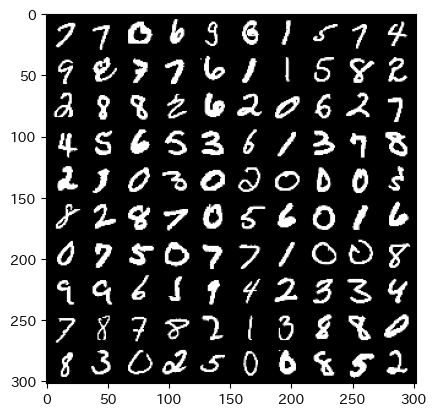

In [ ]:
# train_loaderで読み出した画像を表示してみる
iterator = iter(train_loader)
x, label = next(iterator)
print(label)
imshow(x)

### 訓練の内容を定義する

In [ ]:
def train(net, loss_func, optimizer, epochs, train_loader, device):
    losses = []             # エポック毎の損失
    output_and_label = []   # 復元した画像と正解ラベル
    latent = []

    # エポックの処理
    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0

        # バッチの処理
        for counter, train_batch in enumerate(train_loader, 1):
          # 前回微分値を初期化
          optimizer.zero_grad() # 前回の最適化係数を初期化

          # ミニバッチのデータ前処理
          img, label = train_batch
          if net.__class__.__name__ == "AutoEncoder": # MLPの場合
            # print(net.__class__.__name__)
            img = img.reshape(-1, 28*28) # 入力画像を28 x 28画素データに変換
          img = img.to(device) # CPU/GPUに送信する

          # 訓練
          output, lat = net(img) # netはオートエンコーダ，outputは 28 x 28画素データ

          # 損失計算（入力画像と生成画像の誤差）
          loss = loss_func(output, img) # 入力画素データと出力画素データの平均二乗誤差を計算

          # 勾配（微分）計算
          loss.backward() # 誤差逆伝搬値（最適化係数）を計算

          # ニューラルネットワークのパラメータ値の再設定
          optimizer.step() # 最適化を実施

          # バッチの損失を記録
          running_loss += loss.item()

        # エポック毎に平均損失を再計算
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print(f'loss:{avg_loss:.4f}' )
        # print(f'loss:{avg_loss:.4f}, \tlatent_var:{lat}' )

        # 入力画像と出力画像を記録
        output_and_label.append((output, img))

        # 潜在変数を記録
        latent.append(lat)

    print('finished')
    return output_and_label, losses, latent



# 訓練を実施する
- MLPの場合
  - 50エポックで，GPUで12分程度、CPUでは25分程度かかる

In [ ]:
from datetime import datetime
from torch import optim

# MNIST画像は 1ch x H28 x W28
input_size = 28 * 28 # 画像サイズ（H x W）
latent_dim = z_dim = 10 # 潜在変数の次元数
# latent_dim = z_dim = 4 # 潜在変数の次元数

# ①　学習モデルはオートエンコーダ
net = AutoEncoder(input_size, z_dim) # MLPベース
net = net.to(device) # モデルのパラメータをGPUに送信する

# ②　損失関数は平均二乗誤差
loss_func = torch.nn.MSELoss()

# ③　最適化手法
# optimizer = optim.SGD(net.parameters(), lr=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練回数（100の場合：= 100 x 60,000データ）
# EPOCHS = 100 # latent_dim = 2, 4
EPOCHS = 50 # latent_dim = 10

# タイムスタンプ1
# torch.cuda.synchronize()
t_s = datetime.now()

# 訓練開始
output_and_label, losses, latent = train(net, loss_func, optimizer, EPOCHS, train_loader, device)

# タイムスタンプ2
# torch.cuda.synchronize()
t_e = datetime.now()

# 処理時間
t_p = t_e - t_s
print("処理時間：{} ".format(t_p))

epoch: 1, loss:0.6706
epoch: 2, loss:0.5828
epoch: 3, loss:0.5607
epoch: 4, loss:0.5502
epoch: 5, loss:0.5441
epoch: 6, loss:0.5401
epoch: 7, loss:0.5374
epoch: 8, loss:0.5350
epoch: 9, loss:0.5332
epoch: 10, loss:0.5319
epoch: 11, loss:0.5307
epoch: 12, loss:0.5297
epoch: 13, loss:0.5286
epoch: 14, loss:0.5279
epoch: 15, loss:0.5272
epoch: 16, loss:0.5266
epoch: 17, loss:0.5261
epoch: 18, loss:0.5256
epoch: 19, loss:0.5253
epoch: 20, loss:0.5247
epoch: 21, loss:0.5243
epoch: 22, loss:0.5237
epoch: 23, loss:0.5233
epoch: 24, loss:0.5230
epoch: 25, loss:0.5227
epoch: 26, loss:0.5224
epoch: 27, loss:0.5221
epoch: 28, loss:0.5218
epoch: 29, loss:0.5211
epoch: 30, loss:0.5204
epoch: 31, loss:0.5201
epoch: 32, loss:0.5199
epoch: 33, loss:0.5196
epoch: 34, loss:0.5193
epoch: 35, loss:0.5189
epoch: 36, loss:0.5185
epoch: 37, loss:0.5185
epoch: 38, loss:0.5181
epoch: 39, loss:0.5180
epoch: 40, loss:0.5178
epoch: 41, loss:0.5176
epoch: 42, loss:0.5174
epoch: 43, loss:0.5172
epoch: 44, loss:0.51

### 訓練の様子をグラフ表示で確認する

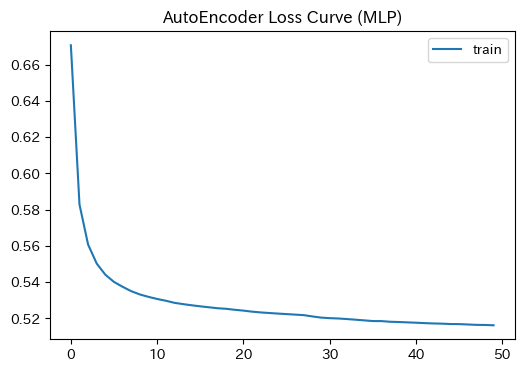

In [ ]:
# 損失が減少していく様子をグラフ表示する
%matplotlib inline
from matplotlib import pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('AutoEncoder Loss Curve (MLP)')
plt.plot(losses,label='train')

plt.legend()
plt.show()

## 生成された手書き文字を表示して確認する
訓練最後のエポックの出力画像

入力画像


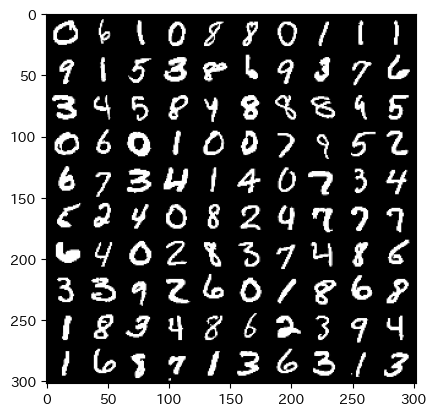

オートエンコーダの生成画像


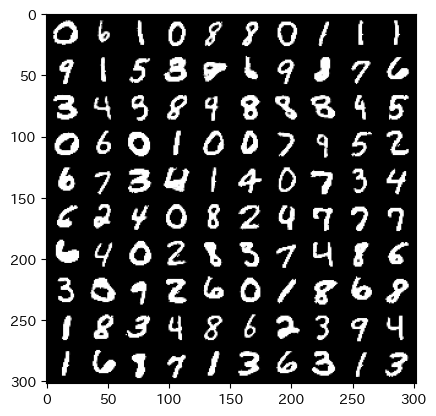

In [ ]:
# 最後のエポックの画像を確認する
output_img, input_img = output_and_label[-1]

print('入力画像')
imshow(input_img.cpu().reshape(-1,1,28,28)) # cpuに送った後，直列化されたデータを画像として再構成

print('オートエンコーダの生成画像')
# imshow(output_img.cpu().reshape(-1,1,28,28)) # 同上
out_file_vae = "./output_ae.png"
imshow_save(output_img.cpu().reshape(-1,1,28,28), out_file_vae)

訓練途中の出力画像も確認

訓練の入力画像


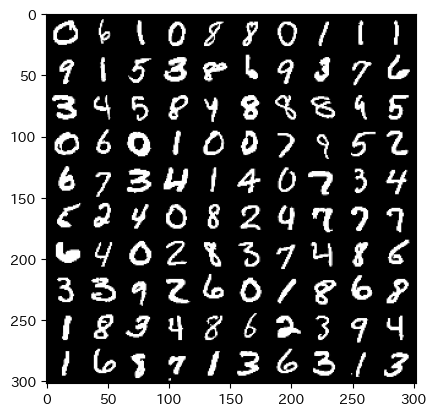

0エボックの出力画像


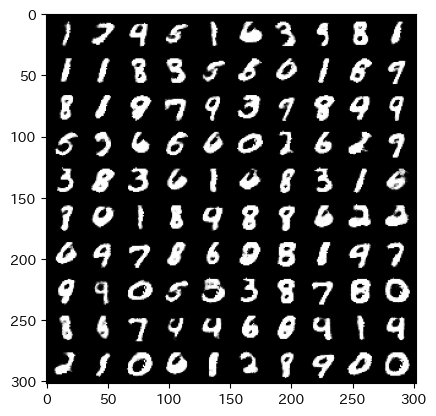

20エボックの出力画像


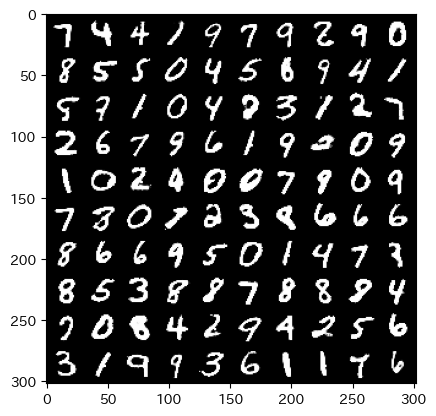

40エボックの出力画像


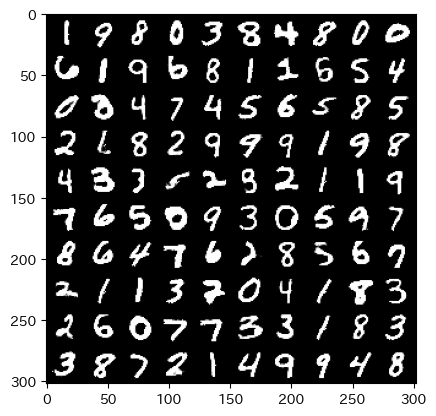

オートエンコーダの生成画像


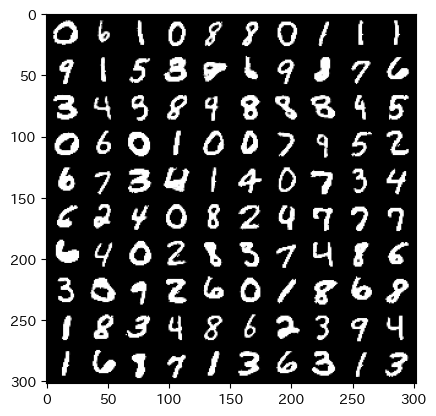

In [ ]:
# 訓練の最初から20エポックおきに生成画像を確認する
print('訓練の入力画像')
imshow(input_img.cpu().reshape(-1,1,28,28)) # cpuに送った後，直列化されたデータを画像として再構成

for i, (o_img, i_img) in enumerate(output_and_label[0::20]):
  print('{}エボックの出力画像'.format(i*20))
  imshow(o_img.cpu().reshape(-1,1,28,28)) # cpuに送った後，直列化されたデータを画像として再構成

print('オートエンコーダの生成画像')
imshow(output_img.cpu().reshape(-1,1,28,28)) # 同上

### 学習済みモデルのパラメータを保存する

In [ ]:
# 学習済みモデルを現在の作業フォルダに保存する
torch.save(net.to('cpu').state_dict(), "./model_AE_mlp_zd10_e50.pth")

# # 保存したモデルを読み込んで利用する場合
# model.load_state_dict(torch.load("model_ft.pth"))

In [ ]:
# フォルダを確認する
!pwd
!ls -l

/content/drive/MyDrive/practice/chap_ae
total 2354
-rw------- 1 root root  146776 May 13 02:56 AE_mlp_zd10_e50_mnist_1000.xlsx
drwx------ 3 root root    4096 May  2 06:44 dataset
-rw------- 1 root root   74827 May 13 02:56 latent1_2_scatter.png
-rw------- 1 root root 1888786 May 13 06:12 model_AE_mlp_zd10_e50.pth
-rw------- 1 root root   79859 May 13 06:10 output_ae.png
-rw------- 1 root root   69531 May 13 03:08 pca_scatter3D.png
-rw------- 1 root root   71255 May 13 03:07 pca_scatter.png
-rw------- 1 root root   72904 May 13 03:09 t-sne_pca_scatter.png


<!--
# B. オートエンコーダで異常検出の可能性を検討する

-->

## 潜在変数（特徴量ベクトル）の分布を表示する
- MNISTテストデータセット
  - テストデータのバッチサイズを1000枚とする

In [ ]:
# テストデータのバッチサイズを大きくする
t_b_size = 1000
test_loader = DataLoader(testset, batch_size=t_b_size, shuffle=False)


In [ ]:
# test_loaderから画像をミニバッチ数だけ読みだすイタレータを作成する
# test_loaderでは1000枚の画像を1バッチ長と設定した
test_iter = iter(test_loader)


In [ ]:
# test_loaderで画像をミニバッチ数だけ読みだす
# test_loaderでは1000枚の画像を1バッチ長と設定した
test_img, label = next(test_iter)
print(test_img.shape)


torch.Size([1000, 1, 28, 28])


<!--
##### 学習済みモデルで推論する
-->

In [ ]:
# モデルのパラメータをCPU/GPUに送信する
net = net.eval().to(device)
# print(net.__class__.__name__)

# テストデータをモデルに入力して推論する（画像を生成する，潜在変数を作成する）
# MNIST（文字画像）
if net.__class__.__name__ == "AutoEncoder": # MLPの場合
  # print(net.__class__.__name__)
  test_img = test_img.reshape(-1, 28*28).to(device) # 入力画像を28 x 28画素データに変換


# 推論を行う
gen_img, latent = net(test_img) # MNIST
# fmnist_gen_img, fmnist_latent = net(fmnist_test_img) # Fashion-MNIST

In [ ]:
# テスト画像の1バッチ分の潜在変数を取得する
# print(latent)
latent_list = latent.cpu().tolist()
print(len(latent_list))
print(latent_list[:3])
# fmnist_latent_list = fmnist_latent.cpu().tolist()

1000
[[-2.8681821823120117, -8.839460372924805, 30.162944793701172, 9.084626197814941, 3.3983006477355957, 3.92097544670105, -2.8320274353027344, -14.171703338623047, -2.286868095397949, -18.39067268371582], [-9.988008499145508, 20.0141658782959, -23.09511947631836, -43.89159393310547, -21.71709442138672, 22.945005416870117, 16.694124221801758, 12.778056144714355, -12.934062957763672, 9.768543243408203], [12.232139587402344, 15.259014129638672, -3.7156424522399902, -8.802591323852539, 0.5849453210830688, -9.781320571899414, 9.246979713439941, -7.188649654388428, -9.6322603225708, -6.44675874710083]]


In [ ]:
# 正解ラベルをListで取得
t_list = label.numpy().tolist()
print(type(t_list))
print(len(t_list))
print(t_list[-3:])

<class 'list'>
1000
[0, 8, 9]


In [ ]:
print(len(x))
print(latent.shape)

100
torch.Size([1000, 10])


In [ ]:
# lat0
lat0_x_list = latent[:,0].cpu().tolist()
print(type(lat0_x_list))
print(len(lat0_x_list))
print(lat0_x_list[-3:])

<class 'list'>
1000
[-53.721683502197266, -32.696868896484375, -2.4254422187805176]


In [ ]:
# lat1
lat1_y_list = latent[:,1].cpu().tolist()
print(type(lat1_y_list))
print(len(lat1_y_list))
print(lat1_y_list[-3:])

<class 'list'>
1000
[-2.3858025074005127, 5.1171369552612305, -16.769819259643555]


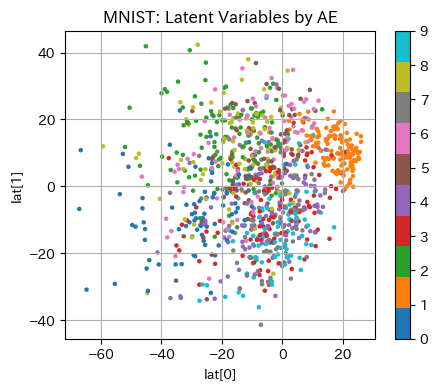

In [ ]:
# 図の大きさをインチ単位で指定する
fig = plt.figure(figsize=(5, 4))

# MNIST
ax1 = fig.add_subplot(111)
ax1.set_title('MNIST: Latent Variables by AE')

# 散布図
mappable = ax1.scatter(lat0_x_list, lat1_y_list, c=t_list, marker="o", s=5, cmap="tab10")

# # 凡例表示
# ax1.legend()
# # ax2.legend()

# 軸タイトル
ax1.set_xlabel("lat[0]")
ax1.set_ylabel("lat[1]")

# グリッド表示
ax1.grid(axis="both")

# カラーバーを付加
fig.colorbar(mappable, ax=ax1)

# グラフをカレントディレクトリにファイルとして保存する
plt.savefig("./latent1_2_scatter.png")

# グラフ表示
plt.show()

# B. 潜在変数で**クラスタリング**の可能性を検討する
- 潜在変数が入力画像の特徴をどの程度内在しているのか確認する
- 潜在変数をさらに次元削減する
  1. PCAで次元削減して散布図表示
  1. さらに，t-SNEで変換処理して散布図表示

In [ ]:
# 潜在変数は10次元ベクトル
print(latent_list[0])

[-2.8681821823120117, -8.839460372924805, 30.162944793701172, 9.084626197814941, 3.3983006477355957, 3.92097544670105, -2.8320274353027344, -14.171703338623047, -2.286868095397949, -18.39067268371582]


In [ ]:
# 処理のし易さから，潜在変数をデータフレームに読み込む
import pandas as pd
df_latent = pd.DataFrame(latent_list)
print(df_latent.head())

           0          1          2          3          4          5  \
0  -2.868182  -8.839460  30.162945   9.084626   3.398301   3.920975   
1  -9.988008  20.014166 -23.095119 -43.891594 -21.717094  22.945005   
2  12.232140  15.259014  -3.715642  -8.802591   0.584945  -9.781321   
3 -25.017679  -3.430825  14.443885  -0.354234  16.715391  15.619559   
4  -9.368827  -6.653955  13.154532   0.763729  10.613563  -3.103693   

           6          7          8          9  
0  -2.832027 -14.171703  -2.286868 -18.390673  
1  16.694124  12.778056 -12.934063   9.768543  
2   9.246980  -7.188650  -9.632260  -6.446759  
3 -24.287716 -21.012598 -18.164316  25.001413  
4  21.765139  -5.280501  25.395765  14.786331  


In [ ]:
# データフレームに正解ラベルも読み込む
df_latent["target"] = t_list
print(df_latent.head())

           0          1          2          3          4          5  \
0  -2.868182  -8.839460  30.162945   9.084626   3.398301   3.920975   
1  -9.988008  20.014166 -23.095119 -43.891594 -21.717094  22.945005   
2  12.232140  15.259014  -3.715642  -8.802591   0.584945  -9.781321   
3 -25.017679  -3.430825  14.443885  -0.354234  16.715391  15.619559   
4  -9.368827  -6.653955  13.154532   0.763729  10.613563  -3.103693   

           6          7          8          9  target  
0  -2.832027 -14.171703  -2.286868 -18.390673       7  
1  16.694124  12.778056 -12.934063   9.768543       2  
2   9.246980  -7.188650  -9.632260  -6.446759       1  
3 -24.287716 -21.012598 -18.164316  25.001413       0  
4  21.765139  -5.280501  25.395765  14.786331       4  


In [ ]:
# データフレームをExcelファイルに出力する
file_name = "./AE_mlp_zd10_e50_mnist_1000.xlsx"
# file_name = "./AE_cnn_zd10_e50_mnist_fmnist.xlsx"
df_latent.to_excel(file_name, index_label=False)

In [ ]:
!ls -F

AE_mlp_zd10_e50_mnist_1000.xlsx  model_AE_mlp_zd10_e50.pth  pca_scatter.png
dataset/			 output_ae.png		    t-sne_pca_scatter.png
latent1_2_scatter.png		 pca_scatter3D.png


## PCA

In [ ]:
# ライブラリ
from sklearn.decomposition import PCA

# PCA法のモデルを定義する
model_pca = PCA(n_components=10) # 元データは10次元

In [ ]:
# データフレームのtarget列以外を配列データ（numpy配列）に変換する
print(df_latent.columns)
features = df_latent[df_latent.columns[df_latent.columns != 'target']].values
# features = df_latent.iloc[:,:-1].values
print(type(features))
print(len(features))
print(features.shape)
print(features[0])

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'target'], dtype='object')
<class 'numpy.ndarray'>
1000
(1000, 10)
[ -2.86818218  -8.83946037  30.16294479   9.0846262    3.39830065
   3.92097545  -2.83202744 -14.17170334  -2.2868681  -18.39067268]


In [ ]:
# PCA法で訓練する
model_pca.fit(features) # スケール変換後のデータを使用する

PCA(n_components=10)

訓練結果として以下の情報が得られる
- model_pca.components_，分散共分散行列
- explained_variance_，固有値
- explained_variance_ratio_，寄与率

主成分の寄与率を棒グラフで確認する<br>

棒グラフ作成には **plt.bar()** を用いる<br>
matplotlip.pyplot.bar() の使い方は[ここ](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.bar.html)を参照のこと．


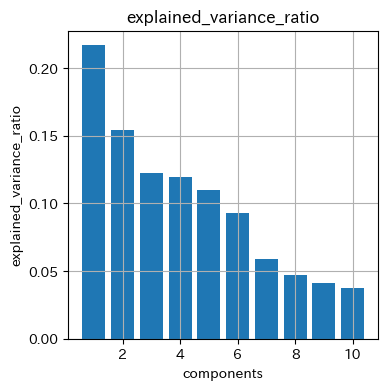

In [ ]:
# ライブラリ
import matplotlib.pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(4,4))

# 寄与率を棒グラフで確認する
"""
# 寄与率は，model_pca.explained_variance_ratio_ に格納されている
# plt.bar(x, height) where x: 1 to num components + 1, height: components ratio
"""
# bar(x, height)
plt.bar([n for n in range(1, len(model_pca.explained_variance_ratio_)+1)], model_pca.explained_variance_ratio_)

# グラフのタイトルをつける
plt.title("explained_variance_ratio")

# 軸ラベルを付ける
plt.xlabel('components')
plt.ylabel('explained_variance_ratio')

# グリッド表示
plt.grid(axis="both")

# 凡例表示
# plt.legend()

# グラフ表示
plt.show()

In [ ]:
# 累積寄与率の大きさ（数値）を確認

sum = 0
sum_list = []
for i in range(10):
  sum += model_pca.explained_variance_ratio_[i]
  sum_list.append(sum)

  print('explained variance ratio: {:.2f}, accumulated ratios: {:.1f}'.format(model_pca.explained_variance_ratio_[i], sum*100))


explained variance ratio: 0.22, accumulated ratios: 21.7
explained variance ratio: 0.15, accumulated ratios: 37.1
explained variance ratio: 0.12, accumulated ratios: 49.3
explained variance ratio: 0.12, accumulated ratios: 61.3
explained variance ratio: 0.11, accumulated ratios: 72.3
explained variance ratio: 0.09, accumulated ratios: 81.6
explained variance ratio: 0.06, accumulated ratios: 87.4
explained variance ratio: 0.05, accumulated ratios: 92.1
explained variance ratio: 0.04, accumulated ratios: 96.3
explained variance ratio: 0.04, accumulated ratios: 100.0


累積寄与率を折れ線グラフにする

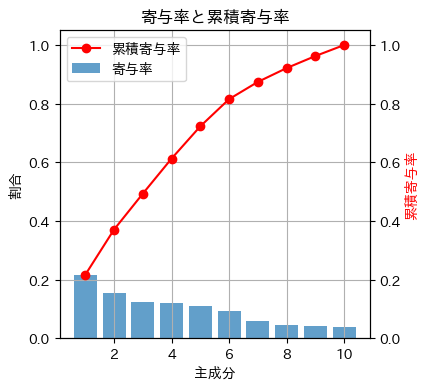

In [ ]:
import matplotlib.pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(4,4))  # 横幅を長くして、2つのグラフを並べて表示

# 寄与率を棒グラフで確認する
x = [n for n in range(1, len(model_pca.explained_variance_ratio_)+1)]
height = model_pca.explained_variance_ratio_
plt.bar(x, height, label='寄与率', alpha=0.7)  # 棒グラフにラベルを追加

# 累積寄与率を折れ線グラフで確認する
sum_list = [0]  # 最初の累積寄与率は0
for i in range(len(model_pca.explained_variance_ratio_)):
    sum_list.append(sum_list[-1] + model_pca.explained_variance_ratio_[i])

# sum_listの最初の要素を削除
del sum_list[0]
plt.plot(x, sum_list, label='累積寄与率', marker='o', linestyle='-', color='red')  # 折れ線グラフを追加

# グラフのタイトルをつける
plt.title("寄与率と累積寄与率")

# 軸ラベルを付ける
plt.xlabel('主成分')
plt.ylabel('割合')

# グリッド表示
plt.grid(axis="both")

# 凡例を表示
plt.legend()

# 目盛りを調整
plt.twinx()  # 右側に目盛りを追加
plt.ylabel('累積寄与率', color='red')  # 右側の目盛りのラベルを設定
plt.ylim(0, 1.05)  # 右側の目盛りの範囲を設定

# グラフ表示
plt.show()


In [ ]:
# 累積寄与率が80%程度以上になる6つの主成分だけを維持
model_pca80 = PCA(n_components=6)
model_pca80.fit(features)

# # 累積寄与率が95%程度になる6つの主成分だけを維持
# model_pca95 = PCA(n_components=8)
# model_pca95.fit(features)

# 6つの主成分の軸に対してデータ変換
pca_X = model_pca80.transform(features)
# pca_X = model_pca95.transform(features)

print(pca_X.shape)
print(type(pca_X))

(1000, 6)
<class 'numpy.ndarray'>


In [ ]:
# グラフ処理のしやすさのためデータフレームに再度変換する

pca_df = pd.DataFrame(pca_X)
print(pca_df.shape)
print(type(pca_df))

(1000, 6)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(pca_df.head())

           0          1          2          3          4          5
0  -1.810249   7.864323 -12.658206 -21.616125  16.685919 -24.602863
1  -8.650494 -30.453351  29.195885  31.667300   4.254422  24.243590
2 -28.787629  -8.712333  -0.023561  -9.057722  -6.421701   2.154348
3  28.177321  -9.036954   6.410139 -15.205576 -14.592165 -28.918461
4   9.940147  28.949476  -1.470315 -14.302233  -2.752082  14.601256


In [ ]:
# 正解ラベル
print(df_latent['target'][:5])

0    7
1    2
2    1
3    0
4    4
Name: target, dtype: int64


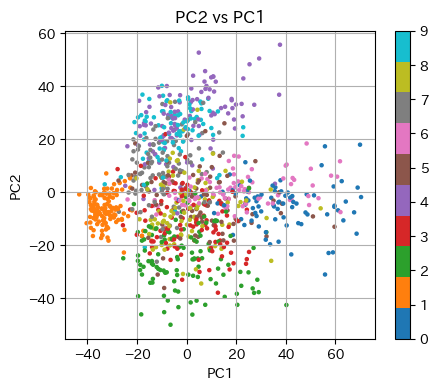

In [ ]:
# 第2主成分までを散布図で表示
""" [演習] 散布図（PC2 vs PC1）
第一主成分：pca_df[0]
第二主成分：pca_df[1]
ラベルはtに格納されている
"""
# t = df_all_latent['flag']
t = df_latent['target']

# 図の大きさをインチ単位で指定する
fig = plt.figure(figsize=(5,4))

# 描画エリア
ax1 = fig.add_subplot(111)

# 散布図をプロットする
# plt.scatter(pca_df[0], pca_df[1], c=t, s=5, cmap="label2color")
mappable = ax1.scatter(pca_df[0], pca_df[1], c=t, s=5, cmap="tab10")

# for i in range(len(pca_df)):
#   x = pca_df[0]
#   y = pca_df[1]
#   t_color = t[i]
#   # print(f'i = {i}, \tx = {x:.2f}, \ty = {y:.2f}')
#   # print(f"t={t[i]}, color={label2color[t[i]]}")
#   plt.scatter(x, y, marker="o",color=label2color[t_color], s=5)

# グラフのタイトルをつける
plt.title("PC2 vs PC1")

# 軸ラベルを付ける
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# グリッド表示
ax1.grid(axis="both")

# カラーバーを付加
fig.colorbar(mappable, ax=ax1)

# # 凡例表示
# plt.legend()

# グラフをカレントディレクトリにファイルとして保存する
# plt.savefig("./pca_scatter.pdf")
# plt.savefig("./pca_scatter.jpg")
plt.savefig("./pca_scatter.png")

# グラフ表示
plt.show()

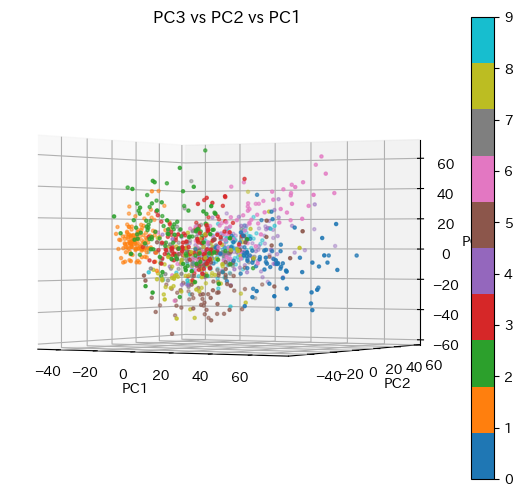

In [ ]:
# 第3主成分までを3D表示する
""" [演習]
第一主成分：pca_df[0]
第二主成分：pca_df[1]
第三主成分：pca_df[2]
ラベルはtに格納されている
"""
# t = df_all_latent['flag']
t = df_latent['target']

# 図の大きさをインチ単位で指定する
fig = plt.figure(figsize=(7,6))

# 描画エリアの作成
ax = fig.add_subplot(projection='3d')

# 表示角度を指定する
ax.view_init(elev=0, azim=-60)

# 散布図をプロットする
mappable = ax.scatter(pca_df[0], pca_df[1], pca_df[2], c=t, s=5, cmap="tab10")

# グラフのタイトルをつける
ax.set_title("PC3 vs PC2 vs PC1")

# 軸ラベルを付ける
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# グリッド表示
# plt.grid(axis="both")

# カラーバーを付加
fig.colorbar(mappable, ax=ax)

# 凡例表示
# plt.legend()

# グラフをカレントディレクトリにファイルとして保存する
# plt.savefig("./pca_scatter3D.pdf")
# plt.savefig("./pca_scatter3D.jpg")
plt.savefig("./pca_scatter3D.png")

# グラフ表示
plt.show()

### t-SNE（t-Distributed Stochastic Neighbor Embedding）
- 次元圧縮と可視化手法
- 原理は各自で調べてください

In [ ]:
from sklearn.manifold import TSNE

# t-SNEモデル
# 二次元に圧縮，初期値はPCAの結果を使用する
model_tsne = TSNE(n_components=2, init="pca", verbose=1)

In [ ]:
# t-SNEで2次元座標系を生成する
tsne_coords = model_tsne.fit_transform(pca_df.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 11.175727
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.818459
[t-SNE] KL divergence after 1000 iterations: 0.854369


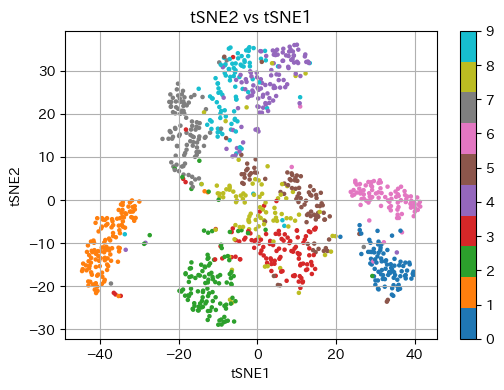

In [ ]:
# 表示する
# import seaborn as sns

# 教師ラベル
t = df_latent['target']

# # # sns
# sns.set(style="white")

# 図の大きさをインチ単位で指定する
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

# 散布図をプロットする
# ax.scatter(tsne_coords[:,0], tsne_coords[:,1], s=10, alpha=1.0, c=t, cmap="winter")
mappable = ax.scatter(tsne_coords[:,0], tsne_coords[:,1], s=5, alpha=1.0, c=t, cmap="tab10")
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")

# グリッド表示
plt.grid(axis="both")

# カラーバーを付加
fig.colorbar(mappable, ax=ax)

# グラフのタイトルをつける
plt.title("tSNE2 vs tSNE1")

# sns
# sns.despine()

# グラフをカレントディレクトリにファイルとして保存する
plt.savefig("./t-sne_pca_scatter.png")

plt.show()

# 発展課題
1. 訓練エポック数を100回程度に増やしてみる
  - 生成される画像の画質がどう変化するのか確認する
  
1. 潜在変数の次元数（z_dim）を2次元，16次元，32次元等に変えてみる
  - 生成される画像の画質がどう変化するのか確認する
  - 潜在変数を散布図表示して，以下がどう変化するか確認する
    - クラスタリング能力

潜在変数の次元数は，エンコーダの出力次元数であり，同時にデコーダの入力次元数であり，これをオートエンコーダのくびれと言ったりネックと言ったりする．


<!--
2. エンコーダの2次元の出力値をX-Y平面にプロットして，エポック数をパラメータとして訓練が進むにつれてどのような軌跡を描くのか確認せよ
3. エンコーダとデコーダをMLPベースのものからCNNベースのものに変更して，生成された画像の質を比較せよ
-->

# まとめ
- オートエンコーダでは，「自己教師あり学習」によって，自分に似た画像が生成できることを確認した
- エンコーダでは，画像を構成している784次元の画像データを10次元のベクトルデータに圧縮した
  - 別の言い方をすれば，エンコーダでは，画像データから特徴量を10次元のベクトルとして抽出する表現学習を行った
- デコーダでは，10次元のベクトルデータから784次元の画像データとして復元した
- 似た画像から抽出される特徴量ベクトルは似た値（近い値）を取ることが分かった
  - これを利用すると，入力画像のクラスタリングに使えそうなことが理解できた
- 推論時に，訓練データと大きく異なる画像データが入力されると，抽出される特徴量ベクトルも，訓練画像データの分布から外れるだろうことが分かった
  - これを利用すると，正常画像で訓練した場合には，正常でない画像（すなわち異常画像）が分別できそうなことが理解できた